# Paper

In [3]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import time
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import sys
sys.path.append('/work/users/d/d/ddinh/aaco/src')
from load_dataset import load_adni_data
from cvar_sensing.utils import prepare_time_series, batch_interp_nd
import torch

2024-11-13 23:10:20.778796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/work/users/d/d/ddinh/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def load_data(file_path):
    ds = load_adni_data(file_path=file_path)
    x = ds.x
    y = ds.y
    mask_nan = np.isnan(x)
    x[mask_nan] = 0
    
    mask_nan_y = np.isnan(y)
    y[mask_nan_y] = 0
    return x, y

train_x, train_y = load_data("/work/users/d/d/ddinh/aaco/input_data/train_data.npz")
val_x, val_y = load_data("/work/users/d/d/ddinh/aaco/input_data/val_data.npz")
test_x, test_y = load_data("/work/users/d/d/ddinh/aaco/input_data/test_data.npz")

num_ts = train_x.shape[1]

In [5]:
from cvar_sensing.encoders import prepare_input, obtain_interpolator
from cvar_sensing.utils import prepare_time_series
from cvar_sensing.utils.interpolation import fillna_nd

In [ ]:
test_sample = np.copy(train_x[:1])
test_sample[:,2:,:] = np.nan
test_sample_ts = prepare_input(torch.Tensor([range(0,num_ts)] * 1), torch.Tensor(test_sample))

In [ ]:
test_sample_ts

(tensor([[ 0.0000,  1.1000,  2.2000,  3.3000,  4.4000,  5.5000,  6.6000,  7.7000,
           8.8000,  9.9000, 11.0000, 12.0000]]),
 tensor([[[ 0.9463, -0.5812,  0.3210,  0.5514],
          [ 0.7560, -0.5812,  0.4868,  1.3533],
          [ 0.7560, -0.5812,  0.4868,  1.3533],
          [ 0.7560, -0.5812,  0.4868,  1.3533],
          [ 0.7560, -0.5812,  0.4868,  1.3533],
          [ 0.7560, -0.5812,  0.4868,  1.3533],
          [ 0.7560, -0.5812,  0.4868,  1.3533],
          [ 0.7560, -0.5812,  0.4868,  1.3533],
          [ 0.7560, -0.5812,  0.4868,  1.3533],
          [ 0.7560, -0.5812,  0.4868,  1.3533],
          [ 0.7560, -0.5812,  0.4868,  1.3533],
          [ 0.7560, -0.5812,  0.4868,  1.3533]]]))

In [18]:
train_x[0]

array([[ 0.946343  , -0.58122814,  0.32096717,  0.55139863],
       [ 0.75595796, -0.58122814,  0.48678538,  1.353316  ],
       [ 0.39508277, -0.58122814,  0.06086014,  0.9956877 ],
       [ 0.24957375, -0.58122814,  0.41200462,  0.4879288 ],
       [ 0.7209328 , -0.58122814,  0.42013296,  0.19132923],
       [ 0.13966939, -0.58122814, -0.06269069, -0.0686531 ],
       [-0.3207443 , -0.58122814,  0.02428259,  0.6319566 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)

In [6]:
def get_ts(x, y): 
    x_data = np.copy(x)
    y_data = np.copy(y)
    x_ts = []
    y_ts = []
    masks = []
    
    for i in range(num_ts):
        x_zero = np.zeros(x_data.shape)
        x_zero[:, :i+1] = x_data[:, :i+1,:]
        
        x_filtered = np.transpose(x_zero, (0, 2, 1)).reshape(-1, x_data.shape[1] * x_data.shape[2])
        
        # zero_mask = np.zeros(x_zero[non_zero_mask,:,:].shape)
        # zero_mask[:,:i+1] = 1
        # zero_mask = np.transpose(zero_mask, (0, 2, 1)).reshape(-1, x_data.shape[1] * x_data.shape[2])
        
        # x_filtered = np.concatenate([x_filtered, zero_mask], axis=1)
        x_filtered = np.concatenate([x_filtered, np.repeat(i, x_filtered.shape[0])[:, None]], axis=1)
        
        x_ts.append(x_filtered)
        y_ts.append(y_data[:, i, :])
        
    x_ts = np.concatenate(x_ts, axis=0)
    y_ts = np.concatenate(y_ts, axis=0)
    
    return x_ts, y_ts

In [7]:
train_x_ts, train_y_ts = get_ts(train_x, train_y)
val_x_ts, val_y_ts = get_ts(val_x, val_y)
test_x_ts, test_y_ts = get_ts(test_x, test_y)

# concatenate train and val
# train_x_ts = np.concatenate([train_x_ts, val_x_ts], axis=0)
# train_y_ts = np.concatenate([train_y_ts, val_y_ts], axis=0)

train_x_ts.shape, train_y_ts.shape
# ((7704, 49), (7704, 3))

((7704, 49), (7704, 3))

In [42]:
train_x_ts[0]

array([ 0.946343  ,  0.946343  ,  0.946343  ,  0.946343  ,  0.946343  ,
        0.946343  ,  0.946343  ,  0.946343  ,  0.946343  ,  0.946343  ,
        0.946343  ,  0.946343  , -0.58122814, -0.58122814, -0.58122814,
       -0.58122814, -0.58122814, -0.58122814, -0.58122814, -0.58122814,
       -0.58122814, -0.58122814, -0.58122814, -0.58122814,  0.32096717,
        0.32096717,  0.32096717,  0.32096717,  0.32096717,  0.32096717,
        0.32096717,  0.32096717,  0.32096717,  0.32096717,  0.32096717,
        0.32096717,  0.55139863,  0.55139863,  0.55139863,  0.55139863,
        0.55139863,  0.55139863,  0.55139863,  0.55139863,  0.55139863,
        0.55139863,  0.55139863,  0.55139863,  0.        ])

In [8]:
masksper = 256 
d = train_x_ts.shape[1] - 1
X_class = np.concatenate([train_x_ts]*masksper, 0)
Y_class = np.concatenate([train_y_ts]*masksper, 0)
B = np.concatenate(
[np.sum(np.random.permutation(np.eye(d))[:, :np.random.randint(d)], 1, keepdims=True) for _ in range(X_class.shape[0])],
1)
B = np.float32(B.T)

zero_mask = X_class[:,:d] == 0
B[zero_mask] = 0

# remove 0 mask
mask_nonzero = np.sum(B, axis=1) != 0
B = B[mask_nonzero]
X_class = X_class[mask_nonzero]
Y_class = Y_class[mask_nonzero]

X_class[:,:d] = X_class[:,:d] * B
X_class.shape, Y_class.shape, B.shape

((1834117, 49), (1834117, 3), (1834117, 48))

In [12]:
location = X_class[:,-1]
X_class = X_class[:,:-1]

In [24]:
X_class = np.transpose(X_class.reshape(-1, train_x.shape[2], train_x.shape[1]), (0, 2, 1))
mask_0 = X_class == 0
X_class[mask_0] = np.nan
X_class = prepare_input(torch.Tensor([range(0,num_ts)] * X_class.shape[0]), torch.Tensor(X_class))[1].numpy()
X_class = np.transpose(X_class, (0, 2, 1)).reshape(-1, train_x.shape[1] * train_x.shape[2])

In [27]:
X_class = np.concatenate([X_class, location[:, None]], axis=1)

In [ ]:
# x_zero[:, i+1:] = np.nan
# x_zero = prepare_input(torch.Tensor([range(0,num_ts)] * x_zero.shape[0]), torch.Tensor(x_zero))[1].numpy()

In [9]:
masksper = 5
d = val_x_ts.shape[1]
X_class_val = np.concatenate([val_x_ts]*masksper, 0)
Y_class_val = np.concatenate([val_y_ts]*masksper, 0)
B_val = np.concatenate(
[np.sum(np.random.permutation(np.eye(d))[:, :np.random.randint(d)], 1, keepdims=True) for _ in range(X_class_val.shape[0])],
1)
B_val = np.float32(B_val.T)

# B_val = np.ones_like(B_val)

zero_mask_val = X_class_val[:,:d] == 0
B_val[zero_mask_val] = 0

# remove 0 mask
mask_nonzero_val = np.sum(B_val, axis=1) != 0
B_val = B_val[mask_nonzero_val]
X_class_val = X_class_val[mask_nonzero_val]
Y_class_val = Y_class_val[mask_nonzero_val]

X_class_val[:,:d] = X_class_val[:,:d] * B_val
X_class_val.shape, Y_class_val.shape, B_val.shape

((8962, 49), (8962, 3), (8962, 49))

In [26]:
val_x.shape

(160, 12, 4)

In [29]:
location_val = X_class_val[:,-1]
X_class_val = X_class_val[:,:-1]

In [31]:
X_class_val = np.transpose(X_class_val.reshape(-1, val_x.shape[2], val_x.shape[1]), (0, 2, 1))
mask_0_val = X_class_val == 0
X_class_val[mask_0_val] = np.nan
X_class_val = prepare_input(torch.Tensor([range(0,num_ts)] * X_class_val.shape[0]), torch.Tensor(X_class_val))[1].numpy()

In [32]:
X_class_val = np.transpose(X_class_val, (0, 2, 1)).reshape(-1, val_x.shape[1] * val_x.shape[2])
X_class_val = np.concatenate([X_class_val, location_val[:, None]], axis=1)

Epoch 1/100
57265/57317 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.3560 - loss: 58.0800 - prc: 0.2640 - roc_auc: 0.6052
Epoch 1: val_roc_auc improved from -inf to 0.64062, saving model to /work/users/d/d/ddinh/aaco/models/mlp_interpolation.keras
57317/57317 ━━━━━━━━━━━━━━━━━━━━ 32s 546us/step - accuracy: 0.3560 - loss: 58.1760 - prc: 0.2640 - roc_auc: 0.6052 - val_accuracy: 0.3448 - val_loss: 391.5270 - val_prc: 0.3050 - val_roc_auc: 0.6406
Epoch 2/100
57269/57317 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.3468 - loss: 773.4655 - prc: 0.2492 - roc_auc: 0.5739
Epoch 2: val_roc_auc improved from 0.64062 to 0.64553, saving model to /work/users/d/d/ddinh/aaco/models/mlp_interpolation.keras
57317/57317 ━━━━━━━━━━━━━━━━━━━━ 31s 547us/step - accuracy: 0.3468 - loss: 773.7755 - prc: 0.2492 - roc_auc: 0.5739 - val_accuracy: 0.3511 - val_loss: 3607.0703 - val_prc: 0.3090 - val_roc_auc: 0.6455
Epoch 3/100
57299/57317 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.3395 - loss: 2614.5

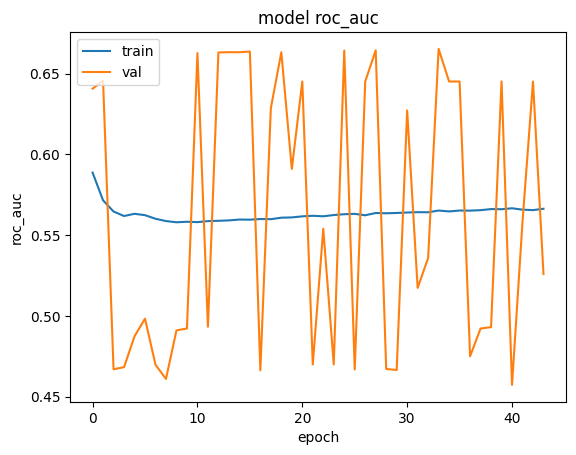

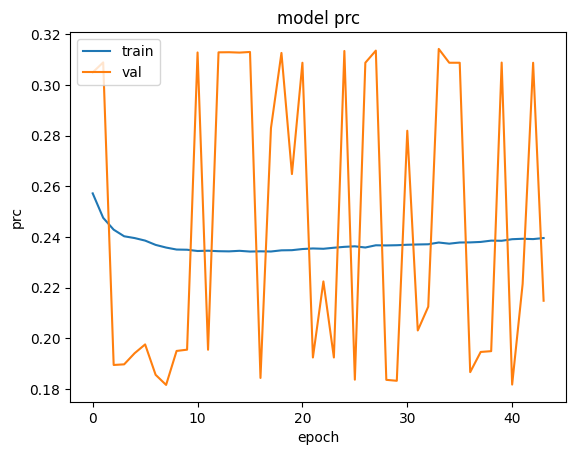

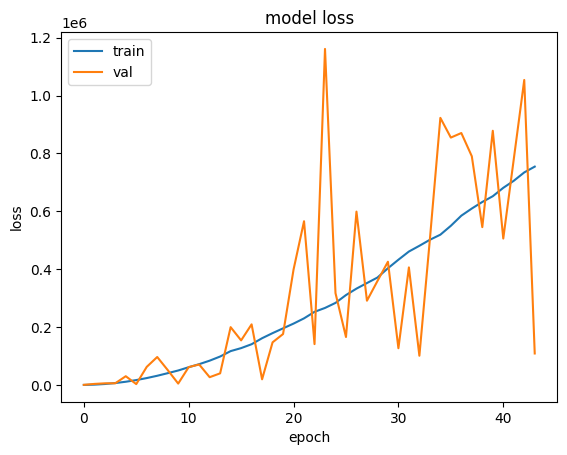

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tensorflow.keras.metrics import AUC

TOTAL_FEATURES = train_x_ts.shape[-1]
HIDDEN_DIM = 10
NUM_CLASSES = train_y_ts.shape[-1]
DROPOUT_RATE = 0.75

def create_mlp():
    model = models.Sequential([
        layers.Input(shape=(TOTAL_FEATURES,)),
        layers.Dense(HIDDEN_DIM, activation='relu'),
        # layers.Dropout(DROPOUT_RATE),
        layers.Dense(HIDDEN_DIM, activation='relu'),
        # layers.Dropout(DROPOUT_RATE),
        layers.Dense(NUM_CLASSES, activation='softmax')  
    ])
    return model



# Compile the model
model = create_mlp()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='roc_auc'), AUC(name='prc', curve='PR')]
)

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    checkpoint = ModelCheckpoint(
        '/work/users/d/d/ddinh/aaco/models/mlp_interpolation.keras',  
        monitor='val_roc_auc',
        mode='max',  
        save_best_only=True,
        verbose=1
    )
    early_stopping = EarlyStopping(
        monitor='val_roc_auc', 
        mode='max', 
        patience=10,  
        verbose=1
    )
    with tf.device('/device:GPU:0'):
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[checkpoint, early_stopping],
            verbose=1
        )
    return history

def evaluate_model(model, X, y):
    loss, accuracy, roc_auc, prc = model.evaluate(X, y, verbose=0)
    print(f"Loss: {loss}, Accuracy: {accuracy}, ROC AUC: {roc_auc}, PRC: {prc}")
    return loss, accuracy, roc_auc

# history = train_model(model, train_x_ts, train_y_ts, val_x_ts, val_y_ts)
# evaluate_model(model, val_x_ts, val_y_ts)
history = train_model(model, X_class, Y_class, X_class_val, Y_class_val)
evaluate_model(model, X_class_val, Y_class_val)

def plot_history(history):
    plt.plot(history.history['roc_auc'])
    plt.plot(history.history['val_roc_auc'])
    plt.title('model roc_auc')
    plt.ylabel('roc_auc')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['prc'])
    plt.plot(history.history['val_prc'])
    plt.title('model prc')
    plt.ylabel('prc')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_history(history)
#  val_prc: 0.5998 - val_roc_auc: 0.7917
# val_accuracy: 0.5886 - val_loss: 0.8313 - val_prc: 0.5985 - val_roc_auc: 0.7912

My version

In [9]:

dataset = load_adni_data()
x = dataset.x
y = dataset.y

mask_nan = np.isnan(x)

x[mask_nan] = 0

num_ts = y.shape[1]


In [10]:
for i in range(num_ts):
    count = [0,0,0]
    total = 0
    for j in range(y.shape[0]):
        for k in range(3):
            if y[j,i,k] == 1:
                count[k] += 1
                total += 1
    count = np.array(count)
    print(count/total)

[0.06387226 0.64271457 0.29341317]
[0.08805668 0.61234818 0.29959514]
[0.10761421 0.59187817 0.30050761]
[0.125      0.58974359 0.28525641]
[0.16613757 0.54179894 0.29206349]
[0.13573883 0.56872852 0.29553265]
[0.178125  0.5796875 0.2421875]
[0.18283582 0.53731343 0.27985075]
[0.17350746 0.46455224 0.3619403 ]
[0.18235294 0.45294118 0.36470588]
[0.18596491 0.49473684 0.31929825]
[0.17098446 0.43005181 0.39896373]


In [11]:
count = [0,0,0]
total = 0
for i in range(num_ts):
    for j in range(y.shape[0]):
        for k in range(3):
            if y[j,i,k] == 1:
                count[k] += 1
                total += 1
count = np.array(count)
print(count/total)

[0.13054449 0.56998672 0.29946879]


In [12]:
mask_nan = x==0
# get the number of nan values
total = mask_nan.sum()
probability = total / x.size
probability

0.40976380572188953

In [13]:
# split dataset into train and test sets 80/20 with random seed 42
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((801, 12, 4), (201, 12, 4), (801, 12, 3), (201, 12, 3))

In [14]:
x_train = prepare_time_series(torch.Tensor([range(0,12)] * x_train.shape[0]), torch.Tensor(x_train))[1]
y_train = prepare_time_series(torch.Tensor([range(0,12)] * y_train.shape[0]), torch.Tensor(y_train))[1]

In [15]:
x_train[0]

tensor([[ 0.3297,  0.1390,  1.3199, -0.0833],
        [ 0.3297,  0.1390,  1.0883,  0.3012],
        [ 0.3297,  0.1390,  0.9298, -0.1822],
        [ 0.3297,  0.1390,  0.9298, -0.1822],
        [ 0.3297,  0.0346,  0.9745,  0.2414],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3297,  0.0346,  0.9745,  0.2414],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3297,  0.4605,  0.9745,  0.2414],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])

In [ ]:
# x_train = torch.cat([x_train, x_train[:, [-1]]], dim=-2).numpy()
# y_train = torch.cat([y_train, y_train[:, [-1]]], dim=-2).numpy()

In [ ]:
# y_train = np.round(y_train)

In [ ]:
# x_ts = []
# y_ts = []

# for i in range(num_ts): 
#     x_temp = np.zeros_like(x_train)
#     x_temp[:, :i+1, :] = x_train[:, :i+1, :]
#     x_ts.append(x_temp)    
#     y_ts.append(y_train)
# x_ts = np.concatenate(x_ts, axis=0)
# y_ts = np.concatenate(y_ts, axis=0)
# x_ts.shape, y_ts.shape

In [ ]:
"""temp
"""
x_ts = x_train
y_ts = y_train

In [ ]:
x_all = []
for item in x_ts:
    x_all.append(item.flatten('F'))
x_train = np.array(x_all)
y_train = y_ts

In [ ]:
import numpy as np

def apply_masks(inputs, pm=0.2, pd_m=0.4):
    inputs = np.copy(inputs).reshape(-1, 12, 4)
    n, T, M = inputs.shape
    masked_inputs = inputs.copy()

    mask_m1 = np.random.binomial(1, pm, size=(n, T, M))
    
    t_max = np.random.randint(0, T, size=n)
    mask_m2 = np.ones((n, T, M))
    for i in range(n):
        mask_m2[i, t_max[i]:] = 0
    
    modality_drop = np.random.binomial(1, pd_m, size=(n, M))
    mask_m3 = np.ones((n, T, M))
    for m in range(M):
        mask_m3[:, :, m] *= modality_drop[:, m].reshape(-1, 1)

    final_mask = mask_m1 * mask_m2 * mask_m3
    masked_inputs *= final_mask

    return masked_inputs, final_mask.reshape(n, -1)

pm = 0.2
pd_m = 0.4 

In [ ]:
masksper = 256 * 2
d = x_train.shape[1]
X_class = np.concatenate([x_train]*masksper, 0)
Y_class = np.concatenate([y_train]*masksper, 0)
# B = np.concatenate(
# [np.sum(np.random.permutation(np.eye(d))[:, :np.random.randint(d)], 1, keepdims=True) for _ in range(X_class.shape[0])],
# 1)
# B = np.float32(B.T)

_, B = apply_masks(X_class, pm, pd_m)
    
"""
remove for interpolation
"""
zero_mask = X_class == 0
B[zero_mask] = 0

# # remove 0 mask
mask_nonzero = np.sum(B, axis=1) != 0
B = B[mask_nonzero]
X_class = X_class[mask_nonzero]
Y_class = Y_class[mask_nonzero]


In [ ]:
# mask_nan = X_class == 0
# B[mask_nan] = 0

In [ ]:
X_class = np.concatenate((X_class*B, B), 1)

In [ ]:
X_class.shape, Y_class.shape

In [ ]:
location = []
for i in range(B.shape[0]):
    b = B[i]
    temp = -1
    for j in range(4):
        part = b[num_ts*j:num_ts*(j+1)]
        max_index = np.where(part == 1)[0]
        if len(max_index) > 0:
            max_index = max_index[-1]
            if max_index > temp:
                temp = max_index
    location.append(temp)
    
location = np.array(location)

In [ ]:
unique, counts = np.unique(location, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
y_temp = []
for i in range(Y_class.shape[0]):
    y_location = Y_class[i, location[i]]
    mask_nan = np.isnan(y_location)
    y_location[mask_nan] = 0
    y_temp.append(y_location)
y_temp = np.array(y_temp)

In [ ]:
# remove y with nan values
mask_zero = np.sum(y_temp, axis=1) != 0
X_class = X_class[mask_zero]
Y_class = y_temp[mask_zero]

In [ ]:
Y_class = np.argmax(Y_class, axis=1)

In [ ]:
# Train classifier
est = XGBClassifier(n_estimators=256, device='gpu')
est.fit(X_class, Y_class)

In [ ]:
# est.save_model('/work/users/d/d/ddinh/aaco/models/adni_different_masking.model')

In [ ]:
x_ts_val = []
y_ts_val = []

for i in range(num_ts): 
    x_temp = np.zeros_like(x_val)
    x_temp[:, :i+1, :] = x_val[:, :i+1, :]
    x_ts_val.append(x_temp)    
    y_ts_val.append(y_val)
x_ts_val = np.concatenate(x_ts_val, axis=0)
y_ts_val = np.concatenate(y_ts_val, axis=0)
x_ts_val.shape, y_ts_val.shape

In [ ]:
x_all_val = []
for item in x_ts_val:
    x_all_val.append(item.flatten('F'))
x_val = np.array(x_all_val)
y_val = y_ts_val

In [ ]:
masksper = 1
d = x_val.shape[1]
X_class_val = np.concatenate([x_val]*masksper, 0)
Y_class_val = np.concatenate([y_val]*masksper, 0)
B_val = np.concatenate(
[np.sum(np.random.permutation(np.eye(d))[:, :np.random.randint(d)], 1, keepdims=True) for _ in range(X_class_val.shape[0])],
1)
B_val = np.float32(B_val.T)

# B_val = np.ones_like(B_val)

zero_mask_val = X_class_val == 0
B_val[zero_mask_val] = 0

# remove 0 mask
mask_nonzero_val = np.sum(B_val, axis=1) != 0
B_val = B_val[mask_nonzero_val]
X_class_val = X_class_val[mask_nonzero_val]
Y_class_val = Y_class_val[mask_nonzero_val]

In [ ]:
location_val = []
for i in range(B_val.shape[0]):
    b = B_val[i]
    temp = -1
    for j in range(4):
        part = b[num_ts*j:num_ts*(j+1)]
        max_index = np.where(part == 1)[0]
        if len(max_index) > 0:
            max_index = max_index[-1]
            if max_index > temp:
                temp = max_index
    location_val.append(temp)
    
location_val = np.array(location_val)

In [ ]:
y_temp_val = []
for i in range(Y_class_val.shape[0]):
    y_location_val = Y_class_val[i, location_val[i]]
    mask_nan_val = np.isnan(y_location_val)
    y_location_val[mask_nan_val] = 0
    y_temp_val.append(y_location_val)
y_temp_val = np.array(y_temp_val)

In [ ]:
# remove y with nan values for validation set
mask_zero_val = np.sum(y_temp_val, axis=1) != 0
X_class_val = X_class_val[mask_zero_val]
Y_class_val = y_temp_val[mask_zero_val]
B_val = B_val[mask_zero_val]

In [ ]:
mask_zero_val.shape

In [ ]:
X_class_val = np.concatenate((X_class_val*B_val, B_val), 1)

In [ ]:
val_preds = est.predict_proba(X_class_val) 

In [ ]:
print(np.mean(np.argmax(val_preds, 1)==np.argmax(Y_class_val, 1)))

In [ ]:
# this is temoprary evaluation, since it's not really correct.
# it should be evaluated on the accumulated predictions, not the individual predictions like this rolling out 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

pr_auc_macro = average_precision_score(Y_class_val, val_preds, average="macro")
print(pr_auc_macro)

roc_auc_macro = roc_auc_score(Y_class_val, val_preds, average="macro", multi_class="ovr")
print(roc_auc_macro)

In [ ]:
np.sum(B_val.mean(0))

In [ ]:
# baseline
# 0.5057228523811975
# 0.6798018971723648

# masking from a2mt paper
# 0.5109105973299515
# 0.7030657167468642